In [1]:
# Import Dependencies
import pandas as pd
from sqlalchemy import create_engine
import datetime
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.corpus import stopwords
import re
import networkx
from textblob import TextBlob

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Create engine 
engine = create_engine("sqlite:///data/hashtag2020.db", echo=True)
conn = engine.connect()

2021-02-10 18:18:49,123 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2021-02-10 18:18:49,125 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 18:18:49,128 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2021-02-10 18:18:49,128 INFO sqlalchemy.engine.base.Engine ()


In [3]:
#Create the table. If we use automap_base, the table must have a primary key
conn.execute("""
    CREATE TABLE IF NOT EXISTS tweet_counts (
        id integer PRIMARY KEY,
        created_at TEXT,
        tweet VARCHAR(280),
        likes integer,
        retweet_count integer,
        source VARCHAR(30),
        lat integer,
        long integer,
        city VARCHAR(100),
        state_code VARCHAR(5),
        hashtag VARCHAR(10),
        Date TEXT,
        Time TEXT,
        polarity integer,
        analysis VARCHAR(20)
        
    )
""")

2021-02-10 18:18:52,517 INFO sqlalchemy.engine.base.Engine 
    CREATE TABLE IF NOT EXISTS tweet_counts (
        id integer PRIMARY KEY,
        created_at TEXT,
        tweet VARCHAR(280),
        likes integer,
        retweet_count integer,
        source VARCHAR(30),
        lat integer,
        long integer,
        city VARCHAR(100),
        state_code VARCHAR(5),
        hashtag VARCHAR(10),
        Date TEXT,
        Time TEXT,
        polarity integer,
        analysis VARCHAR(20)
        
    )

2021-02-10 18:18:52,518 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 18:18:52,523 INFO sqlalchemy.engine.base.Engine COMMIT


In [4]:
conn.execute("""
    CREATE TABLE IF NOT EXISTS state_avg (
        state_code VARCHAR(5) PRIMARY KEY,
        BidenAvg integer,
        TrumpAvg integer
   
    )
""")

2021-02-10 18:18:56,484 INFO sqlalchemy.engine.base.Engine 
    CREATE TABLE IF NOT EXISTS state_avg (
        state_code VARCHAR(5) PRIMARY KEY,
        BidenAvg integer,
        TrumpAvg integer
   
    )

2021-02-10 18:18:56,484 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 18:18:56,496 INFO sqlalchemy.engine.base.Engine COMMIT


In [5]:
conn.execute("""
    CREATE TABLE IF NOT EXISTS time_avg (
        Date TEXT PRIMARY KEY,
        BidenAvg integer,
        TrumpAvg integer
   
    )
""")

2021-02-10 18:18:56,859 INFO sqlalchemy.engine.base.Engine 
    CREATE TABLE IF NOT EXISTS time_avg (
        Date TEXT PRIMARY KEY,
        BidenAvg integer,
        TrumpAvg integer
   
    )

2021-02-10 18:18:56,860 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 18:18:56,865 INFO sqlalchemy.engine.base.Engine COMMIT


In [6]:
conn.execute("""
    CREATE TABLE IF NOT EXISTS sent_count (
        count_id integer PRIMARY KEY,
        analysis VARCHAR(20),
        Biden_Count integer,
        Trump_Count integer
       
    )
""")

2021-02-10 18:18:57,260 INFO sqlalchemy.engine.base.Engine 
    CREATE TABLE IF NOT EXISTS sent_count (
        count_id integer PRIMARY KEY,
        analysis VARCHAR(20),
        Biden_Count integer,
        Trump_Count integer
       
    )

2021-02-10 18:18:57,261 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 18:18:57,273 INFO sqlalchemy.engine.base.Engine COMMIT


In [7]:
conn.execute("""
    CREATE TABLE IF NOT EXISTS time_tweets (
        id integer PRIMARY KEY,
        created_at TEXT,
        trump integer,
        biden integer
        
    )
""")

2021-02-10 18:18:57,699 INFO sqlalchemy.engine.base.Engine 
    CREATE TABLE IF NOT EXISTS time_tweets (
        id integer PRIMARY KEY,
        created_at TEXT,
        trump integer,
        biden integer
        
    )

2021-02-10 18:18:57,700 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 18:18:57,714 INFO sqlalchemy.engine.base.Engine COMMIT


In [8]:
conn.execute("""
    CREATE TABLE IF NOT EXISTS st_tweets (
        id integer PRIMARY KEY,
        state_code TEXT,
        trump integer,
        biden integer
        
    )
""")

2021-02-10 18:18:58,083 INFO sqlalchemy.engine.base.Engine 
    CREATE TABLE IF NOT EXISTS st_tweets (
        id integer PRIMARY KEY,
        state_code TEXT,
        trump integer,
        biden integer
        
    )

2021-02-10 18:18:58,084 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 18:18:58,093 INFO sqlalchemy.engine.base.Engine COMMIT


In [75]:
# Read in CSV's and build initial combined dataframe
trump_csv_path = "../hashtag_donaldtrump.csv"
biden_csv_path = "../hashtag_joebiden.csv"

In [76]:
trump_data_df = pd.read_csv(trump_csv_path, lineterminator='\n')
biden_data_df = pd.read_csv(biden_csv_path, lineterminator='\n')

In [77]:
trump_data_df["hashtag"]="Trump"
biden_data_df["hashtag"]="Biden"

In [12]:
tweet_df = pd.concat([trump_data_df, biden_data_df])

In [13]:
tweet_df["created_at"]=pd.to_datetime(tweet_df.created_at)

In [14]:
tweet_df.sort_values(by = 'created_at')

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtag
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,Trump
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,Biden
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530,Trump
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060,Trump
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591,Trump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970917,2020-11-08 23:59:54,1.325589e+18,"@sammelbis1998 @iheartmindy @bnorthg First, yo...",0.0,0.0,Twitter for iPad,7.687811e+08,Debra,drdeblk,MD. Autism specialist. Film lover. #DumpTrump2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 17:47:56.012674,Trump
970918,2020-11-08 23:59:55,1.325589e+18,OK just had to do it !\n#Trump #CatapultTrump ...,105.0,28.0,Twitter Web App,4.519791e+08,Dunken K Bliths,DunkenKBliths,"""Tesla owner's will be followed back""\n\n#Mach...",...,✔ Official Twitter Account,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 17:47:55.807500,Trump
922910,2020-11-08 23:59:56,1.325589e+18,@nbcbayarea Who doesn’t like dogs or any kind ...,1.0,1.0,Twitter for iPhone,1.182639e+08,Dianna Maria,DiannaMaria,"~ I am a very proud mom of a sweet, kind and c...",...,United States,39.783730,-100.445882,NaN,United States,North America,NaN,NaN,2020-11-09 17:46:06.939099,Trump
737089,2020-11-08 23:59:57,1.325589e+18,#JoeBiden 😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂 https://t.co/Ym...,0.0,0.0,Twitter for iPhone,1.148479e+08,Nataša,PewPeeew,My brain consists of coping mechanisms and vin...,...,Deutschland,51.083420,10.423447,NaN,Germany,Europe,NaN,NaN,2020-11-09 18:26:04.550843,Biden


In [15]:
usa = {"United States of America" : "United States"}
tweet_df['country'].replace(usa, inplace=True)

In [16]:
clean_df = tweet_df.dropna(how='any')

In [17]:
# Filter to data for United States only
clean_df = clean_df.loc[clean_df['country']== 'United States']

In [18]:
print("Count of duplicates: {}".format(clean_df.duplicated(subset=["tweet"]).sum()))

Count of duplicates: 21056


In [19]:
# Remove duplicate tweets, leaving only those with either hashtag not both
print("Original size of df: {}".format(len(clean_df)))
clean_df.drop_duplicates(subset=["tweet"], inplace=True, keep=False)
print("No duplicates size of df : {}".format(len(clean_df)))

Original size of df: 182384
No duplicates size of df : 141640


In [20]:
clean_df.reset_index(inplace=True)

In [21]:
clean_df['Date'] = clean_df['created_at'].dt.strftime('%m/%d/%Y')
clean_df['Time'] = clean_df['created_at'].dt.strftime('%H:%M:%S')

In [22]:
# Setting id column to use as primary key
clean_df = clean_df.rename(columns = {'index': 'id'}, inplace = False)

In [23]:
clean_df = clean_df[['id', 'created_at', 'tweet', 'likes', 'retweet_count', 'source', 'lat', 'long', 'city','state_code','hashtag', 'Date', 'Time']]

In [24]:
clean_df = clean_df[['created_at', 'tweet', 'likes', 'retweet_count', 'source', 'lat', 'long', 'city','state_code','hashtag', 'Date', 'Time']]

In [25]:
clean_df.reset_index(inplace=True)

In [26]:
clean_df = clean_df.rename(columns = {'index': 'id'}, inplace = False)
clean_df.head()

,id,created_at,tweet,likes,retweet_count,source,lat,long,city,state_code,hashtag,Date,Time
0,0,2020-10-15 00:00:02,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,45.520247,-122.674195,Portland,OR,Trump,10/15/2020,00:00:02
1,1,2020-10-15 00:00:08,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,38.894992,-77.036558,Washington,DC,Trump,10/15/2020,00:00:08
2,2,2020-10-15 00:00:26,#Trump #PresidentTrump #Trump2020LandslideVict...,3.0,5.0,Twitter for Android,32.717421,-117.162771,San Diego,CA,Trump,10/15/2020,00:00:26
3,3,2020-10-15 00:01:14,"#Trump: Nobody likes to tell you this, but som...",1.0,1.0,Twitter Web App,45.520247,-122.674195,Portland,OR,Trump,10/15/2020,00:01:14
4,4,2020-10-15 00:01:30,@karatblood @KazePlays_JC Grab @realDonaldTrum...,2.0,0.0,Twitter for iPhone,41.882823,-87.686307,Chicago,IL,Trump,10/15/2020,00:01:30


In [27]:
clean_df['id'].value_counts()

2047      1
34106     1
136552    1
44351     1
42302     1
         ..
125672    1
123625    1
129770    1
127723    1
0         1
Name: id, Length: 141640, dtype: int64

In [28]:
# Sentiment Analysis - code created by Try Suharso https://www.kaggle.com/trysuharso (2020) Pandas, NLTK, Re, TextBlob, Networkx. [Source code]. https://www.kaggle.com/trysuharso/us-election-2020-twitter-analysis

In [29]:
#cleaning the tweets
def clean_tweets(tweet):
 
    tweet = re.sub(r':', '', str(tweet))
    tweet = re.sub(r'‚Ä¶', '', str(tweet))
    tweet = re.sub('@[A-Za-z0–9]+', '', str(tweet))               
    tweet = re.sub('#', '', str(tweet)) # Removing '#' hash tag
    tweet = re.sub('https?:\/\/\S+', '', str(tweet)) # Removing hyperlink
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ',str(tweet))
    tweet = str(tweet).lower()
    tweet = re.sub('\[.*?\]', '', tweet)
    tweet = re.sub('https?://\S+|www\.\S+', '', tweet)
    tweet = re.sub('<.*?>+', '', tweet)
    tweet = re.sub('\n', '', tweet)
    tweet = re.sub('\w*\d\w*', '', tweet)
    tweet = re.sub(r'#','',tweet)
    tweet = re.sub(r'RT[\s]+','',tweet)
    tweet = re.sub(r'[^\w]', ' ', tweet)
    tweet = re.sub('https', '', tweet)
    tweet = re.sub('https ', '', tweet)
    tweet = re.sub('co', '', tweet)

    return tweet

In [30]:
# Determine subjectivity, polarity, sentiment values of each tweet 
# ALLOW SEVERAL MINUTES TO COMPLETE
def getSubjectivity(tweet):
    try:
        return TextBlob(tweet).sentiment.subjectivity
    except:
        return None


# Create a function to get the polarity
def getPolarity(tweet):
    try:
        return  TextBlob(tweet).sentiment.polarity
    except:
        return None

def sentiment_calc(tweet):
    try:
        return TextBlob(tweet).sentiment
    except:
        return None

# Add sentiment analysis value columns to df
clean_df['edited_tweet'] = clean_df['tweet'].apply(clean_tweets)
clean_df['subjectivity'] = clean_df['edited_tweet'].apply(getSubjectivity)
clean_df['polarity'] = clean_df['edited_tweet'].apply(getPolarity)
clean_df['sentiment'] = clean_df['edited_tweet'].apply(sentiment_calc)

# Assign sentiment analysis category based on polarity value and add to df
def getAnalysis(score):
    if score < 0:
      return 'Negative'
    elif score == 0:
      return 'Neutral'
    else:
      return 'Positive'

clean_df['analysis'] = clean_df['polarity'].apply(getAnalysis)

In [31]:
clean_df.head()

,id,created_at,tweet,likes,retweet_count,source,lat,long,city,state_code,hashtag,Date,Time,edited_tweet,subjectivity,polarity,sentiment,analysis
0,0,2020-10-15 00:00:02,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,45.520247,-122.674195,Portland,OR,Trump,10/15/2020,00:00:02,trump as a student i used to hear for years f...,0.333333,0.333333,"(0.3333333333333333, 0.3333333333333333)",Positive
1,1,2020-10-15 00:00:08,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,38.894992,-77.036558,Washington,DC,Trump,10/15/2020,00:00:08,you get a tie and you get a tie trump s ral...,0.000000,0.000000,"(0.0, 0.0)",Neutral
2,2,2020-10-15 00:00:26,#Trump #PresidentTrump #Trump2020LandslideVict...,3.0,5.0,Twitter for Android,32.717421,-117.162771,San Diego,CA,Trump,10/15/2020,00:00:26,trump presidenttrump maga kag america ameri...,0.750000,0.500000,"(0.5, 0.75)",Positive
3,3,2020-10-15 00:01:14,"#Trump: Nobody likes to tell you this, but som...",1.0,1.0,Twitter Web App,45.520247,-122.674195,Portland,OR,Trump,10/15/2020,00:01:14,trump nobody likes to tell you this but some ...,0.595238,0.261905,"(0.2619047619047619, 0.5952380952380952)",Positive
4,4,2020-10-15 00:01:30,@karatblood @KazePlays_JC Grab @realDonaldTrum...,2.0,0.0,Twitter for iPhone,41.882823,-87.686307,Chicago,IL,Trump,10/15/2020,00:01:30,_jc grab by the balls amp chuck the bastar...,1.000000,0.000000,"(0.0, 1.0)",Neutral


In [32]:
# Creating dataframe for polarity average by state
biden=clean_df[clean_df['hashtag']=='Biden']
trump=clean_df[clean_df['hashtag']=='Trump']

In [33]:
biden['Pol_Avg'] = biden.groupby('state_code').polarity.transform('mean')
trump['Pol_Avg'] = trump.groupby('state_code').polarity.transform('mean')


In [34]:
biden = biden[['state_code','lat', 'long', 'hashtag','Pol_Avg' ]]
trump = trump[['state_code','lat', 'long', 'hashtag','Pol_Avg' ]]

In [35]:
biden = biden.drop_duplicates(subset=['state_code'], keep='first')
trump = trump.drop_duplicates(subset=['state_code'], keep='first')

In [36]:
biden['analysis'] = biden['Pol_Avg'].apply(getAnalysis)
trump['analysis'] = trump['Pol_Avg'].apply(getAnalysis)

In [37]:
biden['analysis'].value_counts()

Positive    52
Name: analysis, dtype: int64

In [38]:
trump['analysis'].value_counts()

Positive    46
Negative     5
Name: analysis, dtype: int64

In [39]:
biden.head()

,state_code,lat,long,hashtag,Pol_Avg,analysis
75874,CA,34.053691,-118.242766,Biden,0.099392,Positive
75875,NY,40.712728,-74.006015,Biden,0.103448,Positive
75876,MN,44.977300,-93.265469,Biden,0.083951,Positive
75878,IN,39.768333,-86.158350,Biden,0.115800,Positive
75879,FL,26.358688,-80.083098,Biden,0.104468,Positive


In [40]:
biden = biden.rename(columns = {'Pol_Avg': 'BidenAvg'}, inplace = False).reset_index()
trump = trump.rename(columns = {'Pol_Avg': 'TrumpAvg'}, inplace = False).reset_index()

In [41]:
biden = biden[['state_code', 'BidenAvg']]
trump = trump[['state_code', 'TrumpAvg']]

In [42]:
state_avg = pd.merge(biden, trump, on="state_code", how="left")

In [43]:
state_avg = state_avg.reset_index(drop=True)

In [44]:
state_avg.head()

,state_code,BidenAvg,TrumpAvg
0,CA,0.099392,0.037021
1,NY,0.103448,0.041554
2,MN,0.083951,0.013977
3,IN,0.115800,-0.008091
4,FL,0.104468,0.047393


In [45]:
# Sentiment by date

In [46]:
biden1=clean_df[clean_df['hashtag']=='Biden']
trump1=clean_df[clean_df['hashtag']=='Trump']

In [47]:
biden1['Pol_Avg'] = biden1.groupby('Date').polarity.transform('mean')
trump1['Pol_Avg'] = trump1.groupby('Date').polarity.transform('mean')

In [48]:
biden1.head()

,id,created_at,tweet,likes,retweet_count,source,lat,long,city,state_code,hashtag,Date,Time,edited_tweet,subjectivity,polarity,sentiment,analysis,Pol_Avg
75874,75874,2020-10-15 00:01:57,@RealJamesWoods #BidenCrimeFamily #JoeBiden #H...,0.0,0.0,Twitter for Android,34.053691,-118.242766,Los Angeles,CA,Biden,10/15/2020,00:01:57,bidencrimefamily joebiden hunterbiden hunterb...,0.000000,0.000000,"(0.0, 0.0)",Neutral,0.060676
75875,75875,2020-10-15 00:02:06,Come on @ABC PLEASE DO THE RIGHT THING. Move t...,0.0,0.0,Twitter Web App,40.712728,-74.006015,New York,NY,Biden,10/15/2020,00:02:06,me on please do the right thing move the bid...,0.178571,0.078571,"(0.07857142857142857, 0.17857142857142858)",Positive,0.060676
75876,75876,2020-10-15 00:02:23,#realDonaldTrump addresses #JoeBiden and #Hunt...,0.0,1.0,Twitter for iPhone,44.977300,-93.265469,Minneapolis,MN,Biden,10/15/2020,00:02:23,realdonaldtrump addresses joebiden and hunterb...,0.500000,0.500000,"(0.5, 0.5)",Positive,0.060676
75877,75877,2020-10-15 00:03:17,"Hunter #Biden introduced his father, then-Vice...",1.0,0.0,Twitter for Android,40.712728,-74.006015,New York,NY,Biden,10/15/2020,00:03:17,hunter biden introduced his father then vice ...,0.322222,0.044444,"(0.044444444444444446, 0.32222222222222224)",Positive,0.060676
75878,75878,2020-10-15 00:03:24,This is from the same night I met the cast of ...,0.0,0.0,Twitter for iPhone,39.768333,-86.158350,Indianapolis,IN,Biden,10/15/2020,00:03:24,this is from the same night i met the cast of ...,0.125000,0.000000,"(0.0, 0.125)",Neutral,0.060676


In [49]:
biden1 = biden1.drop_duplicates(subset=['Date'], keep='first')
trump1 = trump1.drop_duplicates(subset=['Date'], keep='first')

In [50]:
biden1 = biden1.rename(columns = {'Pol_Avg': 'BidenAvg'}, inplace = False).reset_index()
trump1 = trump1.rename(columns = {'Pol_Avg': 'TrumpAvg'}, inplace = False).reset_index()

In [51]:
biden1 = biden1[['Date', 'BidenAvg']]
trump1 = trump1[['Date', 'TrumpAvg']]

In [52]:
time_avg = pd.merge(biden1, trump1, on="Date", how="left")

In [53]:
time_avg = time_avg.reset_index(drop=True)

In [54]:
time_avg.head()

,Date,BidenAvg,TrumpAvg
0,10/15/2020,0.060676,0.025188
1,10/16/2020,0.098555,0.034679
2,10/17/2020,0.097150,0.023844
3,10/18/2020,0.061264,0.024387
4,10/19/2020,0.066724,0.034913


In [55]:
# Creating dataframe for sentiment counts bar visual
biden_count=clean_df[clean_df['hashtag']=='Biden']
trump_count=clean_df[clean_df['hashtag']=='Trump']


In [56]:
biden_count = biden_count[['analysis', 'hashtag']]
trump_count = trump_count[['analysis', 'hashtag']]

In [57]:
biden_count["count"]=1
trump_count["count"]=1

In [58]:
biden_count.head()

,analysis,hashtag,count
75874,Neutral,Biden,1
75875,Positive,Biden,1
75876,Positive,Biden,1
75877,Positive,Biden,1
75878,Neutral,Biden,1


In [59]:
biden_count = biden_count.rename(columns = {'count': 'Biden_Count'}, inplace = False)
trump_count = trump_count.rename(columns = {'count': 'Trump_Count'}, inplace = False)

In [60]:
biden_count.head()

,analysis,hashtag,Biden_Count
75874,Neutral,Biden,1
75875,Positive,Biden,1
75876,Positive,Biden,1
75877,Positive,Biden,1
75878,Neutral,Biden,1


In [61]:
biden_count = biden_count.groupby('analysis').count().reset_index()
trump_count = trump_count.groupby('analysis').count().reset_index()

In [62]:
biden_count = biden_count[['analysis', 'Biden_Count']]
trump_count = trump_count[['analysis', 'Trump_Count']]

In [63]:
sent_count = pd.merge(biden_count, trump_count, on="analysis", how="left")
sent_count

,analysis,Biden_Count,Trump_Count
0,Negative,9762,17547
1,Neutral,29940,31606
2,Positive,26064,26721


In [64]:
sent_count = sent_count.reset_index(drop=True)

In [65]:
sent_count

,analysis,Biden_Count,Trump_Count
0,Negative,9762,17547
1,Neutral,29940,31606
2,Positive,26064,26721


In [66]:

sent_count = sent_count.reset_index(drop=True)

In [67]:
sent_count.reset_index(inplace=True)
sent_count = sent_count.rename(columns = {'index': 'count_id'}, inplace = False)

In [68]:
sent_count

,count_id,analysis,Biden_Count,Trump_Count
0,0,Negative,9762,17547
1,1,Neutral,29940,31606
2,2,Positive,26064,26721


In [69]:
clean_df = clean_df[['id', 'created_at', 'tweet', 'likes', 'retweet_count', 'source', 'lat', 'long', 'city','state_code','hashtag', 'Date', 'Time', 'polarity', 'analysis']]

In [70]:
clean_df.head()

,id,created_at,tweet,likes,retweet_count,source,lat,long,city,state_code,hashtag,Date,Time,polarity,analysis
0,0,2020-10-15 00:00:02,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,45.520247,-122.674195,Portland,OR,Trump,10/15/2020,00:00:02,0.333333,Positive
1,1,2020-10-15 00:00:08,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,38.894992,-77.036558,Washington,DC,Trump,10/15/2020,00:00:08,0.000000,Neutral
2,2,2020-10-15 00:00:26,#Trump #PresidentTrump #Trump2020LandslideVict...,3.0,5.0,Twitter for Android,32.717421,-117.162771,San Diego,CA,Trump,10/15/2020,00:00:26,0.500000,Positive
3,3,2020-10-15 00:01:14,"#Trump: Nobody likes to tell you this, but som...",1.0,1.0,Twitter Web App,45.520247,-122.674195,Portland,OR,Trump,10/15/2020,00:01:14,0.261905,Positive
4,4,2020-10-15 00:01:30,@karatblood @KazePlays_JC Grab @realDonaldTrum...,2.0,0.0,Twitter for iPhone,41.882823,-87.686307,Chicago,IL,Trump,10/15/2020,00:01:30,0.000000,Neutral


In [71]:
clean_df.to_sql("tweet_counts", conn, if_exists="append", index=False)


2021-02-10 18:22:33,833 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("tweet_counts")
2021-02-10 18:22:33,834 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 18:22:33,925 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-02-10 18:22:35,574 INFO sqlalchemy.engine.base.Engine INSERT INTO tweet_counts (id, created_at, tweet, likes, retweet_count, source, lat, long, city, state_code, hashtag, "Date", "Time", polarity, analysis) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
2021-02-10 18:22:35,575 INFO sqlalchemy.engine.base.Engine ((0, '2020-10-15 00:00:02.000000', "#Trump: As a student I used to hear for years, for ten years, I heard China! In 2019! And we have 1.5 and they don't know how many we have and I asked them how many do we have and they said 'sir we don't know.' But we have millions. Like 300 million.\n\nUm. What?", 2.0, 1.0, 'Twitter Web App', 45.5202471, -122.6741949, 'Portland', 'OR', 'Trump', '10/15/2020', '00:00:02', 0.3333333333333333, 'Positive'

In [72]:
state_avg.to_sql("state_avg", conn, if_exists="append", index=False)

2021-02-10 18:22:36,893 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("state_avg")
2021-02-10 18:22:36,894 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 18:22:36,895 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-02-10 18:22:36,896 INFO sqlalchemy.engine.base.Engine INSERT INTO state_avg (state_code, "BidenAvg", "TrumpAvg") VALUES (?, ?, ?)
2021-02-10 18:22:36,896 INFO sqlalchemy.engine.base.Engine (('CA', 0.09939159968131162, 0.03702110671525558), ('NY', 0.10344838032552992, 0.04155397075305936), ('MN', 0.08395119478640736, 0.013977221125006377), ('IN', 0.11579950574302984, -0.008091308210297927), ('FL', 0.10446779222602395, 0.047393137851233266), ('WA', 0.08308876586170412, 0.03924344947931256), ('GA', 0.09758913543872866, 0.05624893096485214), ('AZ', 0.09465267623280446, 0.043020462933770896)  ... displaying 10 of 52 total bound parameter sets ...  ('ME', 0.1, 0.03662743506493507), ('WY', 0.12272727272727273, 0.05391143578643579))
2021-02-10 18:22:36,898 INF

In [73]:
time_avg.to_sql("time_avg", conn, if_exists="append", index=False)

2021-02-10 18:22:36,909 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("time_avg")
2021-02-10 18:22:36,909 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 18:22:36,910 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-02-10 18:22:36,912 INFO sqlalchemy.engine.base.Engine INSERT INTO time_avg ("Date", "BidenAvg", "TrumpAvg") VALUES (?, ?, ?)
2021-02-10 18:22:36,912 INFO sqlalchemy.engine.base.Engine (('10/15/2020', 0.06067589120651807, 0.02518750876489242), ('10/16/2020', 0.09855521471410528, 0.03467861474195017), ('10/17/2020', 0.09714979183628335, 0.023843874844916485), ('10/18/2020', 0.061264448963361626, 0.024387091832695898), ('10/19/2020', 0.0667239491199359, 0.03491276811243676), ('10/20/2020', 0.06297745488287522, 0.02892980267507632), ('10/21/2020', 0.08749802847988328, 0.0347671114104597), ('10/22/2020', 0.07153124951654775, 0.03273767311827945)  ... displaying 10 of 25 total bound parameter sets ...  ('11/07/2020', 0.14033738088831127, 0.046316710071235334)

In [74]:
sent_count.to_sql("sent_count", conn, if_exists="append", index=False)

2021-02-10 18:22:36,941 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("sent_count")
2021-02-10 18:22:36,942 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 18:22:36,942 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-02-10 18:22:36,943 INFO sqlalchemy.engine.base.Engine INSERT INTO sent_count (count_id, analysis, "Biden_Count", "Trump_Count") VALUES (?, ?, ?, ?)
2021-02-10 18:22:36,944 INFO sqlalchemy.engine.base.Engine ((0, 'Negative', 9762, 17547), (1, 'Neutral', 29940, 31606), (2, 'Positive', 26064, 26721))
2021-02-10 18:22:36,945 INFO sqlalchemy.engine.base.Engine COMMIT


# Buckley's Code

In [78]:
trump_data_df.sort_values(by = 'created_at')

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtag
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,Trump
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530,Trump
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060,Trump
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591,Trump
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,Trump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970915,2020-11-08 23:59:48,1.325589e+18,JOE BIDEN WHY JOE BIDEN DID WINNED ?? TRUMP TR...,4.0,0.0,Twitter Web App,3.245258e+09,ahzy,ahhhzy,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 17:47:55.715870,Trump
970916,2020-11-08 23:59:53,1.325589e+18,#AfD|ler reagieren panisch bis hysterisch auf ...,25.0,4.0,Twitter Web App,9.866108e+17,watchdog,wilke_tobias,Quis custodiet ipsos custodes?\n\nTV Journalis...,...,Saxony/GER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 17:47:55.975868,Trump
970917,2020-11-08 23:59:54,1.325589e+18,"@sammelbis1998 @iheartmindy @bnorthg First, yo...",0.0,0.0,Twitter for iPad,7.687811e+08,Debra,drdeblk,MD. Autism specialist. Film lover. #DumpTrump2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 17:47:56.012674,Trump
970918,2020-11-08 23:59:55,1.325589e+18,OK just had to do it !\n#Trump #CatapultTrump ...,105.0,28.0,Twitter Web App,4.519791e+08,Dunken K Bliths,DunkenKBliths,"""Tesla owner's will be followed back""\n\n#Mach...",...,✔ Official Twitter Account,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 17:47:55.807500,Trump


In [79]:
biden_data_df.sort_values(by = 'created_at')

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtag
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,Biden
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283,Biden
2,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,...,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566,Biden
3,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0.0,0.0,Twitter for iPhone,8.242596e+17,Michelle Ferg,MichelleFerg4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849,Biden
4,2020-10-15 00:00:22,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,...,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132,Biden
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776882,2020-11-08 23:59:38,1.325589e+18,Ωχ ελπίζω να μη μας βγει σαν τους οπαδούς του...,0.0,0.0,Twitter for Android,4.032819e+08,οχι άλλο κάρβουνο 🇬🇷🗣🗣🗣,anapodoi,ακραία καιρικά φαινόμενα... ζήσαμε και απόψε,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 18:32:45.947617,Biden
776883,2020-11-08 23:59:41,1.325589e+18,L'OTAN va sortir de sa léthargie et redevenir ...,48.0,14.0,Twitter for Android,7.819183e+17,🇫🇷 Alt-Droite (matricule 6921) ✝️ 🇬🇷 🇮🇹 🇦🇲,CtrlAltDroite,Fils de mineur. Libertés - Identité - Solidari...,...,France,46.603354,1.888334,NaN,France,Europe,NaN,NaN,2020-11-09 18:32:45.627335,Biden
776884,2020-11-08 23:59:52,1.325589e+18,🌎\n\n“#congiuntifuoriregione”\n\n‘Sono felice ...,1.0,1.0,Twitter for iPhone,5.293315e+08,Angelo Tani,AngeloTani,nato a casa dei nonni,...,🌎,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 18:32:45.599846,Biden
737089,2020-11-08 23:59:57,1.325589e+18,#JoeBiden 😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂 https://t.co/Ym...,0.0,0.0,Twitter for iPhone,1.148479e+08,Nataša,PewPeeew,My brain consists of coping mechanisms and vin...,...,Deutschland,51.083420,10.423447,NaN,Germany,Europe,NaN,NaN,2020-11-09 18:26:04.550843,Biden


In [80]:
usa = {"United States of America" : "United States"}
trump_data_df['country'].replace(usa, inplace=True)
biden_data_df['country'].replace(usa, inplace=True)

In [81]:
trump_data_df = trump_data_df.dropna(how='any')
biden_data_df = biden_data_df.dropna(how='any')

In [82]:
trump_data_df = trump_data_df.loc[trump_data_df['country']== 'United States']
biden_data_df = biden_data_df.loc[biden_data_df['country']== 'United States']

In [83]:
print("Count of duplicates: {}".format(trump_data_df.duplicated(subset=["tweet"]).sum()))
print("Count of duplicates: {}".format(biden_data_df.duplicated(subset=["tweet"]).sum()))

Count of duplicates: 1421
Count of duplicates: 807


In [84]:
print("Original size of df: {}".format(len(trump_data_df)))
trump_data_df.drop_duplicates(subset=["tweet"], inplace=True, keep=False)
print("No duplicates size of df : {}".format(len(trump_data_df)))

print("Original size of df: {}".format(len(biden_data_df)))
biden_data_df.drop_duplicates(subset=["tweet"], inplace=True, keep=False)
print("No duplicates size of df : {}".format(len(biden_data_df)))

Original size of df: 96623
No duplicates size of df : 94581
Original size of df: 85761
No duplicates size of df : 84461


In [85]:
trump_data_df.reset_index(inplace=True)
biden_data_df.reset_index(inplace=True)

In [86]:
trump_data_df.head(3)

,index,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtag
0,2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8436472.0,snarke,snarke,...,Portland,45.520247,-122.674195,Portland,United States,North America,Oregon,OR,2020-10-21 00:00:00.746433060,Trump
1,4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,47413798.0,Rana Abtar - رنا أبتر,Ranaabtar,...,Washington DC,38.894992,-77.036558,Washington,United States,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,Trump
2,11,2020-10-15 00:00:25,1.316529e+18,"In 2020, #NYPost is being #censorship #CENSORE...",0.0,0.0,Twitter for iPhone,19940334.0,Change Illinois | Biden will increase taxes by...,changeillinois,...,"Chicago, Illinois",41.875562,-87.624421,Chicago,United States,North America,Illinois,IL,2020-10-21 00:00:04.105381834,Trump


In [87]:
trump_data_df = trump_data_df.rename(columns = {'index': 'id'}, inplace = False)
trump_data_df.head(3)

,id,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtag
0,2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8436472.0,snarke,snarke,...,Portland,45.520247,-122.674195,Portland,United States,North America,Oregon,OR,2020-10-21 00:00:00.746433060,Trump
1,4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,47413798.0,Rana Abtar - رنا أبتر,Ranaabtar,...,Washington DC,38.894992,-77.036558,Washington,United States,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,Trump
2,11,2020-10-15 00:00:25,1.316529e+18,"In 2020, #NYPost is being #censorship #CENSORE...",0.0,0.0,Twitter for iPhone,19940334.0,Change Illinois | Biden will increase taxes by...,changeillinois,...,"Chicago, Illinois",41.875562,-87.624421,Chicago,United States,North America,Illinois,IL,2020-10-21 00:00:04.105381834,Trump


In [88]:
biden_data_df = biden_data_df.rename(columns = {'index': 'id'}, inplace = False)
biden_data_df.head(3)

,id,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtag
0,6,2020-10-15 00:00:25,1.316529e+18,"In 2020, #NYPost is being #censorship #CENSORE...",0.0,0.0,Twitter for iPhone,1.994033e+07,Change Illinois | Biden will increase taxes by...,changeillinois,...,"Chicago, Illinois",41.875562,-87.624421,Chicago,United States,North America,Illinois,IL,2020-10-21 00:00:03.106963698,Biden
1,17,2020-10-15 00:01:23,1.316530e+18,"Comments on this? ""Do Democrats Understand how...",0.0,0.0,Twitter Web App,1.016593e+08,John Ubaldi,ubaldireports,...,"Tampa, Florida",27.947760,-82.458444,Tampa,United States,North America,Florida,FL,2020-10-21 00:00:08.803063811,Biden
2,25,2020-10-15 00:01:57,1.316530e+18,@RealJamesWoods #BidenCrimeFamily #JoeBiden #H...,0.0,0.0,Twitter for Android,1.300837e+18,Sam KEYS,SamKEYS65729181,...,"Los Angeles, CA",34.053691,-118.242766,Los Angeles,United States,North America,California,CA,2020-10-21 00:00:12.945682075,Biden


In [89]:
t_time_series = pd.Series(1, index=trump_data_df['created_at'])
t_time_series.head(3)

created_at
2020-10-15 00:00:02    1
2020-10-15 00:00:08    1
2020-10-15 00:00:25    1
dtype: int64

In [90]:
b_time_series = pd.Series(1, index=biden_data_df['created_at'])
b_time_series.head(3)

created_at
2020-10-15 00:00:25    1
2020-10-15 00:01:23    1
2020-10-15 00:01:57    1
dtype: int64

In [91]:
# Converting the index as date
t_time_series.index = pd.to_datetime(t_time_series.index)
trump_df = t_time_series.resample('12H').sum()
trump_df.head(3)

created_at
2020-10-15 00:00:00    1063
2020-10-15 12:00:00    1535
2020-10-16 00:00:00    1912
Freq: 12H, dtype: int64

In [92]:
b_time_series.index = pd.to_datetime(b_time_series.index)
biden_df = b_time_series.resample('12H').sum()
biden_df.head(3)

created_at
2020-10-15 00:00:00     814
2020-10-15 12:00:00    1239
2020-10-16 00:00:00    1601
Freq: 12H, dtype: int64

In [93]:
t_time_series_df = pd.DataFrame(trump_df)
t_time_series_df.head()

,0
created_at,
2020-10-15 00:00:00,1063
2020-10-15 12:00:00,1535
2020-10-16 00:00:00,1912
2020-10-16 12:00:00,1958
2020-10-17 00:00:00,874


In [94]:
b_time_series_df = pd.DataFrame(biden_df)
b_time_series_df.head()

,0
created_at,
2020-10-15 00:00:00,814
2020-10-15 12:00:00,1239
2020-10-16 00:00:00,1601
2020-10-16 12:00:00,1366
2020-10-17 00:00:00,612


In [95]:
combined_df = pd.concat([t_time_series_df, b_time_series_df], axis=1, join="inner")
combined_df.head()

,0,0
created_at,,
2020-10-15 00:00:00,1063,814
2020-10-15 12:00:00,1535,1239
2020-10-16 00:00:00,1912,1601
2020-10-16 12:00:00,1958,1366
2020-10-17 00:00:00,874,612


In [96]:
combined_df.columns = ['trump', 'biden']
combined_df.head(3)

,trump,biden
created_at,,
2020-10-15 00:00:00,1063,814
2020-10-15 12:00:00,1535,1239
2020-10-16 00:00:00,1912,1601


In [97]:
combined_df.reset_index(inplace=True)



In [98]:
combined_df = combined_df[['created_at','trump','biden']]
combined_df.head(3)

,created_at,trump,biden
0,2020-10-15 00:00:00,1063,814
1,2020-10-15 12:00:00,1535,1239
2,2020-10-16 00:00:00,1912,1601


In [99]:
#Plotting bar graph to show how many tweets by day
combined_df.plot(kind='bar', title='Number of Tweets per Candidate per 12 Hours', figsize=(20,10), width = 0.5)
plt.xlabel('Day')
plt.ylabel('Number of Tweets')

Text(0, 0.5, 'Number of Tweets')

ValueError: view limit minimum 0.0 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [100]:
biden_st=biden_data_df[biden_data_df['hashtag']=='Biden']
biden_st.head(3)


,id,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtag
0,6,2020-10-15 00:00:25,1.316529e+18,"In 2020, #NYPost is being #censorship #CENSORE...",0.0,0.0,Twitter for iPhone,1.994033e+07,Change Illinois | Biden will increase taxes by...,changeillinois,...,"Chicago, Illinois",41.875562,-87.624421,Chicago,United States,North America,Illinois,IL,2020-10-21 00:00:03.106963698,Biden
1,17,2020-10-15 00:01:23,1.316530e+18,"Comments on this? ""Do Democrats Understand how...",0.0,0.0,Twitter Web App,1.016593e+08,John Ubaldi,ubaldireports,...,"Tampa, Florida",27.947760,-82.458444,Tampa,United States,North America,Florida,FL,2020-10-21 00:00:08.803063811,Biden
2,25,2020-10-15 00:01:57,1.316530e+18,@RealJamesWoods #BidenCrimeFamily #JoeBiden #H...,0.0,0.0,Twitter for Android,1.300837e+18,Sam KEYS,SamKEYS65729181,...,"Los Angeles, CA",34.053691,-118.242766,Los Angeles,United States,North America,California,CA,2020-10-21 00:00:12.945682075,Biden


In [101]:
trump_st=trump_data_df[trump_data_df['hashtag']=='Trump']
trump_st.head(3)

,id,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtag
0,2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8436472.0,snarke,snarke,...,Portland,45.520247,-122.674195,Portland,United States,North America,Oregon,OR,2020-10-21 00:00:00.746433060,Trump
1,4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,47413798.0,Rana Abtar - رنا أبتر,Ranaabtar,...,Washington DC,38.894992,-77.036558,Washington,United States,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,Trump
2,11,2020-10-15 00:00:25,1.316529e+18,"In 2020, #NYPost is being #censorship #CENSORE...",0.0,0.0,Twitter for iPhone,19940334.0,Change Illinois | Biden will increase taxes by...,changeillinois,...,"Chicago, Illinois",41.875562,-87.624421,Chicago,United States,North America,Illinois,IL,2020-10-21 00:00:04.105381834,Trump


In [102]:
biden_st_df = biden_st[['state_code', 'hashtag','created_at']]
trump_st_df = trump_st[['state_code', 'hashtag','created_at']]

In [103]:
biden_st_series = pd.Series(1, index=biden_st_df['state_code'])
biden_st_series.head(3)

state_code
IL    1
FL    1
CA    1
dtype: int64

In [104]:
trump_st_series = pd.Series(1, index=trump_st_df['state_code'])
trump_st_series.head(3)

state_code
OR    1
DC    1
IL    1
dtype: int64

In [105]:
biden_st_df = pd.DataFrame(biden_st_series)
biden_st_df.head()

,0
state_code,
IL,1
FL,1
CA,1
NY,1
MN,1


In [106]:
biden_st_df.columns = ['biden']
biden_st_df.head(3)

,biden
state_code,
IL,1
FL,1
CA,1


In [107]:
biden_count = biden_st_df.groupby('state_code')['biden'].value_counts()
biden_count.head(3)

state_code  biden
AK          1        121
AL          1        275
AR          1         66
Name: biden, dtype: int64

In [108]:
trump_st_df = pd.DataFrame(trump_st_series)
trump_st_df.head()

,0
state_code,
OR,1
DC,1
IL,1
CA,1
OR,1


In [109]:
trump_st_df.columns = ['trump']
trump_st_df.head(3)

,trump
state_code,
OR,1
DC,1
IL,1


In [110]:
trump_count = trump_st_df.groupby('state_code')['trump'].value_counts()
trump_count.head(3)

state_code  trump
AK          1         87
AL          1        293
AR          1         68
Name: trump, dtype: int64

In [111]:
combined_count_df = pd.concat([trump_count, biden_count], axis=1)
combined_count_df.head()

,,trump,biden
AK,1,87.0,121
AL,1,293.0,275
AR,1,68.0,66
AZ,1,1600.0,1728
CA,1,18103.0,15838


Text(0, 0.5, 'Number of Tweets')

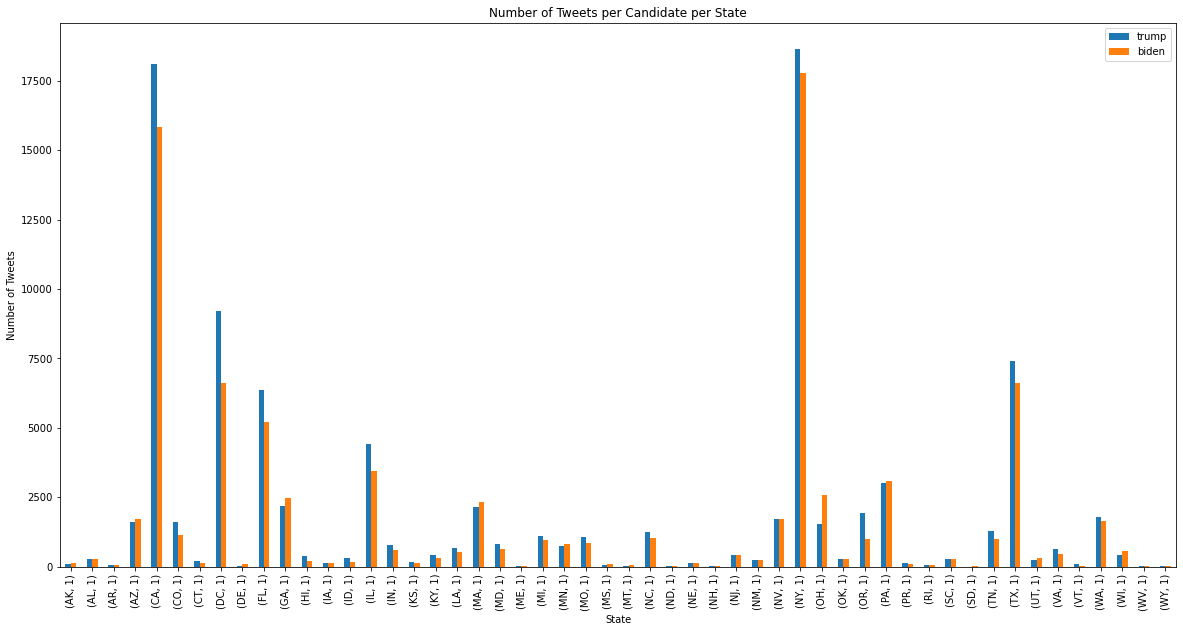

In [112]:
#Plotting bar graph to show how many tweets by day
combined_count_df.plot(kind='bar', title='Number of Tweets per Candidate per State', figsize=(20,10), width = 0.5)
plt.xlabel('State')
plt.ylabel('Number of Tweets')

In [113]:
combined_df.to_sql("time_tweets", conn, if_exists="append", index=False)

2021-02-10 18:24:16,255 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("time_tweets")
2021-02-10 18:24:16,256 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 18:24:16,256 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-02-10 18:24:16,258 INFO sqlalchemy.engine.base.Engine INSERT INTO time_tweets (created_at, trump, biden) VALUES (?, ?, ?)
2021-02-10 18:24:16,259 INFO sqlalchemy.engine.base.Engine (('2020-10-15 00:00:00.000000', 1063, 814), ('2020-10-15 12:00:00.000000', 1535, 1239), ('2020-10-16 00:00:00.000000', 1912, 1601), ('2020-10-16 12:00:00.000000', 1958, 1366), ('2020-10-17 00:00:00.000000', 874, 612), ('2020-10-17 12:00:00.000000', 1382, 1009), ('2020-10-18 00:00:00.000000', 800, 478), ('2020-10-18 12:00:00.000000', 1616, 1012)  ... displaying 10 of 50 total bound parameter sets ...  ('2020-11-08 00:00:00.000000', 2211, 4434), ('2020-11-08 12:00:00.000000', 2134, 1988))
2021-02-10 18:24:16,262 INFO sqlalchemy.engine.base.Engine COMMIT


In [114]:
combined_count_df.to_sql("st_tweets", conn, if_exists="append", index=False)

2021-02-10 18:24:17,523 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("st_tweets")
2021-02-10 18:24:17,523 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 18:24:17,525 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-02-10 18:24:17,525 INFO sqlalchemy.engine.base.Engine INSERT INTO st_tweets (trump, biden) VALUES (?, ?)
2021-02-10 18:24:17,526 INFO sqlalchemy.engine.base.Engine ((87.0, 121), (293.0, 275), (68.0, 66), (1600.0, 1728), (18103.0, 15838), (1595.0, 1124), (191.0, 142), (9207.0, 6618)  ... displaying 10 of 52 total bound parameter sets ...  (14.0, 23), (37.0, 19))
2021-02-10 18:24:17,530 INFO sqlalchemy.engine.base.Engine COMMIT
